In [22]:
import seaborn as sns
import pandas as pd
import mdtraj as md
import os
from numba import jit
import numpy as np
import scipy.signal
import re

#Matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches


import MDAnalysis as mda
import nglview as nv
from MDAnalysis import transformations



# Setings

In [23]:
SIMULATIONTIME = 200 #in NS please
CLUSTERING=False
GLOBAL_YLIM_SSCONV=(-3,71)
GLOBAL_YLIM_RMSD=(0,17)
GLOBAL_YLIM_RMSF=(0,2)

In [24]:
def custom_time(simulationTime, numberOfFrames, start=0):
    time = [start]
    step = np.round(simulationTime/numberOfFrames, 2)
    for i in range(1, numberOfFrames):
        time.append(time[i-1]+step)
    return np.asarray(time)

def write_vmd(topol, trajectory, output="viztest.vmd", smooth=5, highlights=[], superpose=None, traj=None):

    if superpose and traj:
        superposed_traj = traj[:]
        superposed_traj.superpose(superposed_traj, 0, superposed_traj.top.select(superpose))
        trajectory = trajectory.split('.')[0]+"_superposed"+".xtc"
        superposed_traj.save_xtc(trajectory)

    cmd = ""
    cmd += "axes location off\n"
    #Read trajectory
    cmd += f"mol new {topol} type pdb first 0 last -1 step 1 filebonds 1 autobonds 1 waitfor all\n"
    cmd += f"mol addfile {trajectory} type xtc first 0 last -1 step 1 filebonds 1 autobonds 1 waitfor all\n"

    # Add cartoon
    cmd += "mol delrep 0 top\n"
    cmd += "mol representation NewCartoon 0.300000 10.000000 4.100000 0\n"
    cmd += "mol color Structure\n"
    cmd += "mol selection {protein}\n"
    cmd += "mol material AOChalky\n"
    cmd += "mol addrep top\n"
    cmd += f"mol smoothrep top 0 {smooth}\n"

    # Add ions
    cmd += "mol representation VDW 1.000000 12.000000\n"
    cmd += "mol color Name\n"
    cmd += "mol selection {ions}\n"
    cmd += "mol material AOChalky\n"
    cmd += "mol addrep top\n"
    cmd += f"mol smoothrep top 1 {smooth}\n"

    if len(highlights) > 0:
        for highlight in highlights:
            start = highlight[0]
            end = highlight[1]
            viz = highlight[2]
            cmd += f"mol representation {viz} 0.660000 10.000000 4.100000 0\n"
            cmd += "mol color ColorID 1\n"
            cmd += f"mol selection {{resid {start} to {end}}}\n"
            cmd += "mol material Transparent\n"
            cmd += "mol addrep top\n"
            cmd += f"mol smoothrep top 2 {smooth}\n"

    with open(output, 'w') as out:
        out.write(cmd)
        


In [25]:
apoeNumber=2
NMR=False
GMX=True
# baseFolder="/Users/thibault/Documents/WORK/simu/apoe"
baseFolder="D:/work/ApoE/simulation/apoe"


if GMX:
    trajectoryFile = f"md_APOE{apoeNumber}_clean_nowat.xtc"
    topology = f"md_APOE{apoeNumber}_clean_nowat.pdb"
    workdir = f"{baseFolder}/apoe{apoeNumber}/results/replica_1/prod"
    if NMR:
        trajectoryFile = f"md_2l7b_clean_nowat.xtc"
        topology = f"md_2l7b_clean_nowat.pdb"
        workdir = f"{baseFolder}/nmr/results/replica_1/prod"
else:
    trajectoryFile = f"apoe{apoeNumber}_nowat.xtc"
    topology = "topol.pdb"
    workdir = f"{baseFolder}/namd-reza/apoe{apoeNumber}"

#workdir = "D:/work/ApoE/simulation/apoe4/results/replica_1/prod"
os.chdir(workdir)
traj = md.load(trajectoryFile, top=topology)
if SIMULATIONTIME:
    traj.time = custom_time(SIMULATIONTIME, traj.n_frames)

write_vmd(topology, trajectoryFile, highlights=[[206,299, "NewCartoon"]], superpose="residue 10 to 200", traj=traj)


In [26]:

replica = 1
outputPNGdir = f"{workdir}/analysis/PNG"
outputCSVdir = f"{workdir}/analysis/CSV"
if not os.path.exists(outputPNGdir):
    os.makedirs(outputPNGdir)
if not os.path.exists(outputCSVdir):
    os.makedirs(outputCSVdir)




## Functions

In [27]:
def save_fig(figname,outputdir,format="png",dpi=300,bbox_inches='tight', transparent=False):
    from pathlib import Path
    Path(f"{outputdir}").mkdir(parents=True, exist_ok=True)

    plt.savefig(f"{outputdir}/{figname}.{format}", dpi=dpi, bbox_inches=bbox_inches, transparent=transparent)

### Graphs

In [28]:
def do_alignment(traj, selection, referenceFrame=0):
    selectedAtoms = improvedSelection(traj, selection)
    traj.superpose(traj, referenceFrame, selectedAtoms)
    return traj

def Graph_XY(results, X="Time (ns)", Y="RMSD (A)", col="red", title="XY Graph [please set title]", vlines=None, ylim="global", linestyle="dotted"):
    if "Average" in results.columns:

        fig = plt.figure(constrained_layout=True, figsize=(10,5))
        # ax=fig.add_gridspec(ncols=2, nrows=1, width_ratios=[10,1], height_ratios=[1])
        # ax0 = plt.subplot(gs[0,0])
        ax = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[10,1], height_ratios=[1], figure=fig)
        ax.update(hspace=0.05)
        ax0 = plt.subplot(ax[0,0])
        ax1 = plt.subplot(ax[0,1])

        if len(results[X]) > 100:  # For big dataset, average the graph
            graph1 = sns.lineplot(x=X,
                            y=Y,
                            data=results,
                            #legend=False, 
                            #title="{} for {}".format("aType", "name"),
                            color="gray",
                            ax=ax0,
                            linewidth=1,
                            linestyle   =linestyle,
                            )
            graph1.set(ylabel=Y, title=title)
            if ylim == "global" and GLOBAL_YLIM_RMSD:
                graph1.set_ylim(GLOBAL_YLIM_RMSD)
            elif type(ylim) == list or type(ylim) == tuple:
                graph1.set_ylim(ylim)
            

            average = sns.lineplot(x=X, y="Average", data=results, legend=False, color=col, ax=ax0,linewidth=1,)
            

            violin = sns.violinplot(y=Y, data=results, ax=ax1, color="gray")
            violin.set(xlabel="",ylabel="", yticks=[], xticks=[])
            #Apply same axis
            ax1.set_ylim(ax0.get_ylim())

            ax0.set_xlabel(X)
            
        else:
            ax = results.plot(x=X, y=Y, legend=False, title=title,
                                figsize=(7, 4), color=col)
            ax.set(ylabel=Y)
            fig = ax.get_figure()

    return None

def graph_RMSF(results, X="Residue", Y="RMSD (A)", title="XY Graph [please set title]", col='black', vlines=None):
    fig,ax = plt.subplots(figsize=(10,5))
    #This is for RMSF
    vlines=[112, 158]
    graph=sns.lineplot(x="Residue",y="RMSF (A)", data=results, color=col)
    for x in vlines:
        plt.axvline(x=x, color='grey', linewidth=1, linestyle="dotted")
    graph.set(ylabel=Y, xlabel=X, title=title)
    if GLOBAL_YLIM_RMSF:
        graph.set_ylim(GLOBAL_YLIM_RMSF)



def graph_SS(dss, title = "please set title", regions=[]):
    """

    """
    
    plt.style.use('seaborn-white')
    fig,ax = plt.subplots(figsize=(12,7))

    conversionDict = {"H": 0, "E": 1, "C": 2, "": 3, "B": 4, "G": 5, "I": 6, "T": 7, "S": 8, ' ': 3}

    colorDict = {0: "red", 1: "yellow", 2: "white", 3: "white", 4: "orange", 5: "magenta", 6: "pink", 7: "cyan",
                    8: "green", }

    labelDict = {0: "Helix", 1: "Sheet", 2: "Coil", 3: "Loop", 4: "Beta-Bridge", 5: "3/10 helix", 6: "pi helix",
                    7: "Turn", 8: "Bend", }

    

    for key in conversionDict.keys():
        dss[dss == key] = conversionDict[key]
    dss = dss.astype(int)

    # Define matplotlib colors
    col = ['r', '#FFFF00', 'w', '#DCDCDC', '#FFA500', 'm', '#FFC0CB', 'c', 'b']
    cmap = colors.ListedColormap(col)
    boundaries = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

    unique = pd.unique(dss.values.ravel('K'))
    

    #patches = [mpatches.Patch(color=col[i], label=labelDict[i]) for i in range(len(labelDict.values()))]
    patches = [mpatches.Patch(color=col[index], label=labelDict[index]) for index in unique]


    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Residue")
    ax.set_title(title)

    #Add H1, H2, H3, H3
    for label in regions:
        borders = regions[label]
        y1 = borders[0]
        y2 = borders[1]
        if len(borders) == 3:
            color = borders[3]
        else:
            color = "black"
        ax.axhspan(y1, y2, zorder=10, alpha=1, color=color, label=label, fill=False, linewidth=2, linestyle=":")



    plt.imshow(dss, cmap=cmap, norm=norm, aspect="auto", interpolation="None")
    plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=True)

    # fig.tight_layout()

    plt.style.use('ggplot')  # Restore previous style
    

def graph_TRRMSF(resultsDF):
    """
    Default function to generate XY graphs (most of graph types)
    :param resultsDF: Pandas DataFrame
    :return:
    """

    fig,ax = plt.subplots(figsize=(12,7))


    graph = sns.heatmap(resultsDF.T, ax=ax)
    lw = 10/resultsDF.T.shape[0]

    for i in range(len(resultsDF) + 1):
        ax.axhline(i, color='white', lw=lw)
    graph.set(title="TimeResolved-RMSF", ylabel="Frame", xlabel="Residue Number")
    


def Graph_SS_percentage(data, title="please set title", stride=10):

    fig,ax = plt.subplots(figsize=(10,5))

    labelDict = {0: "Helix", 1: "Sheet", 2: "Coil", 3: "Loop", 4: "Beta-Bridge", 5: "3/10 helix", 6: "pi helix",
                        7: "Turn", 8: "Bend", 'C':"Coil", 'H':'Helix','E':'Sheet'}
    df = data.replace(labelDict)
    df.iloc[:,0].value_counts(normalize=True)
    df = df.apply(lambda x: x.value_counts(normalize=True)).T
    df = df.fillna(0)
    df = df.stack()
    df = df.reset_index().rename(columns={"level_0":"Time (ns)", "level_1":"SecStruc",0:"percentage"})
    df["Time (ns)"] = df["Time (ns)"].astype(np.float32)
    df["percentage"] = df["percentage"]*100
    graph = sns.lineplot(x="Time (ns)", y="percentage", hue="SecStruc", data=df.iloc[::stride], ci=None, hue_order = ["Helix","Coil","Sheet"], palette=["#ff0000","#707070",'#fbff00'])
    graph.set(title=title)
    if GLOBAL_YLIM_SSCONV:
        graph.set_ylim(GLOBAL_YLIM_SSCONV)


def graph_HBOND(data, xlabel="Frame", ylabel='', title=None,cutoff=0.1, figsize=(12,9), grouped=True):
    """
    Data Has to be a dataframe
    """
    #RESET HBONDS GRAPH
    #self.figures = []
    plt.clf()
    plt.style.use('seaborn-white')
    filteredData = data.query("Freq > @cutoff")
    filteredData = filteredData.sort_values("Freq", ascending=False)
    from matplotlib.colors import LinearSegmentedColormap


    if grouped:
        new_index=[f"{x.split('-')[0]} --{x.split('-')[3]}" for x in filteredData.index]
        filteredData.index = new_index
        filteredData = filteredData.reset_index().groupby("index").sum()


    #Define CMAP
    maxval = filteredData.values.max()

    if maxval == 1:
        colors = ["white","black"]
    elif maxval == 2:
        colors = ["white","gray","black"]
    elif maxval == 3:
        colors = ["white","gray","blue","red"]
    elif maxval == 4:
        colors = ["white","gray","blue","green","red"]
    elif maxval == 5:
        colors = ["white","gray","blue","green","orange","red"]
    else:
        print(f"ERROR, cmap not define for {maxval} possibilities. Please edit the graph_HBOND function.")
        return 0
    
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=maxval+1)

    indexes = list(filteredData.index)
    # Add percentage

    percentage = np.array(filteredData["Freq"].values * 100)

    labels = []
    for i in range(len(indexes)):
        index = indexes[i]
        percent = percentage[i]
        labels.append("{} | {:3.1f}%".format(indexes[i], percentage[i]))

    values = filteredData.drop("Freq", axis=1).to_numpy()

    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title is None:
        title=f"Hbonds with filter above {cutoff*100}%"
    ax.set_title(title)
    ax.set_yticks(list(range(len(labels))))
    ax.set_yticklabels(labels)

    graph = plt.imshow(values, 
                       cmap=cmap,
                       aspect="auto",
                       interpolation='None',
                       )
    cbar = plt.colorbar(graph)
    

    
    labels = np.arange(0, int(maxval+1), 1)
    step = maxval/len(labels)
    pos = [step/2]
    for i in range(1,len(labels)):
        pos.append(pos[i-1]+step)
 


    #cbar.set_ticks([0.4,1.2,2.0,2.8,3.6])
    cbar.set_ticks(pos)
    cbar.set_ticklabels(labels)

    fig.tight_layout()
    return cbar



def calc_summed_graph(resultsDF, yAxisLabel="Number of HBonds",xAxisLabel="Time (ns)", ylim=None):
    """
    Calculate the summed graphic (another graph that can be done on MD trajectories).
    Args:
        resultsDF (pandas.DataFrame): Dataframe with all the results
        imgPath (string): output folder for graphic saving.
    """
    dat = resultsDF.drop("Freq", axis="columns").sum(axis=0)
    time = list(resultsDF.drop("Freq", axis="columns").columns)
    count = pd.DataFrame({yAxisLabel: dat,
                            xAxisLabel: time})

    if len(count) > 100:
        count["Average"] = scipy.signal.savgol_filter(count[yAxisLabel], 21, 3)

    Graph_XY(count, xAxisLabel, yAxisLabel, ylim=None, linestyle="-") 



### Calculation

In [29]:
def improvedSelection(traj, selection):
    if "within" in selection.lower():
        sepRegex = r"(and|or)"
        separator = re.findall(sepRegex, selection)
        split = re.split(sepRegex, selection)
        topology = traj[0].topology
        selectionString = "[atom.index for atom in topology.atoms if ("
        for sel in split:
            if sel not in ["or", "and", "OR", "AND", "&&", "||"]:
                if "within" in sel.lower():
                    withinRegex = re.search(r"within (\d.?\d*) of (.+)", sel)
                    # Distance unit are in nm.
                    # So convert A to NM.
                    cutoff = float(withinRegex.group(1)) / 10
                    withinOf = withinRegex.group(2)
                    withinIndex = md.compute_neighbors(traj[0],
                                                        cutoff=cutoff,
                                                        query_indices=traj[0].top.select(withinOf))[0]
                    closeIndexes = "("
                    closeIndexes += ' or '.join([f"(atom.index == {index})" for index in withinIndex])
                    closeIndexes += ")"
                    selectionString += closeIndexes

                else:
                    match = re.search(r"(\(.+\))", traj[0].top.select_expression(sel))
                    if match:
                        selectionString += match.group(1)
                    else:
                        match = re.search(r"atom\.index for atom in topology\.atoms if (.*)]$",
                                            traj[0].top.select_expression(sel))
                        selectionString += match.group(1)

            else:
                selectionString += f" {sel} "
        selectionString += ')]'

        selectedAtoms = eval(selectionString)
    else:
        selectedAtoms = traj.top.select(selection)

    return selectedAtoms



#@jit(nopython=True, parallel=False, cache=False, nogil=True)
def calc_rmsd_2frames(ref, frame):
    """
    THIS FUNCTION IS OUT OF THE CLASS BECAUSE OF NUMBA
    RMSD calculation between a reference and a frame.
    This function is "jitted" for better performances
    """
    # #Loop seems faster with numba
    dist = np.zeros(len(frame))
    for atom in range(len(frame)):
        dist[atom] = ((ref[atom][0] - frame[atom][0]) ** 2 +
                      (ref[atom][1] - frame[atom][1]) ** 2 +
                      (ref[atom][2] - frame[atom][2]) ** 2)

    return (np.sqrt(dist.mean()))

def do_rmsd(traj, selection, referenceFrame=0):
    """
    Main calculation function. It has to return a dataframe object with the results
    Args:
        traj (mdtraj.trajectory):  trajectory object

    Returns:
        rmsdDF (pandas.DataFrame):  DataFrame with all the results
    """


    atomsel = traj.top.select(selection)
    subtraj = traj.atom_slice(atomsel, inplace=False)
    yAxisLabel = "RMSD (A)"
    xAxisLabel = "Time (ns)"

    rmsd = np.zeros(subtraj.n_frames)

    calc_function = jit(nopython=True, parallel=False, cache=False, nogil=True)(calc_rmsd_2frames)

    for i in range(subtraj.n_frames):
        rmsd[i] = calc_function(subtraj.xyz[referenceFrame], subtraj.xyz[i])


    rmsdDF = pd.DataFrame({yAxisLabel: rmsd * 10,
                            xAxisLabel: traj.time})
    rmsdDF["Average"] = scipy.signal.savgol_filter(rmsdDF[yAxisLabel], 21, 3)
    return rmsdDF


def do_gyration(traj, selection):
    """
    Main calculation function. It has to return a dataframe object with the results
    Args:
        traj (mdtraj.trajectory):  trajectory object

    Returns:
        rmsdDF (pandas.DataFrame):  DataFrame with all the results
    """


    atomsel = traj.top.select(selection)
    subtraj = traj.atom_slice(atomsel, inplace=False)
    yAxisLabel = "Gyration (A)"
    xAxisLabel = "Time (ns)"


    rg = md.compute_rg(subtraj)


    rgDF = pd.DataFrame({yAxisLabel: rg * 10,
                            xAxisLabel: traj.time})
    rgDF["Average"] = scipy.signal.savgol_filter(rgDF[yAxisLabel], 21, 3)
    return rgDF




def do_rmsf(traj, selection, includeAlignment=False,referenceFrame=0, groupPerResidue=True):
        """
        Main calculation function. It has to return a dataframe object with the results
        Args:
            traj (mdtraj.trajectory):  trajectory object

        Returns:
            rmsfDF (pandas.DataFrame):  DataFrame with all the results
        """
        yAxisLabel = "RMSF (A)"
        xAxisLabel = "Residue"


        # Extract trajectory for time optimisation
        selected_atoms = improvedSelection(traj, selection)
        
        subtraj = traj.atom_slice(selected_atoms)
        if includeAlignment:
            subtraj.superpose(subtraj)

        
        #Calculating homemade RMSF to avoid, alignment issue.
        average_coords = np.mean(subtraj.xyz, axis=0)
        rmsf = np.sqrt(3 * np.mean((subtraj.xyz[:, :, :] - average_coords) ** 2, axis=(0, 2)))


        if groupPerResidue:
            table, bonds = subtraj.top.to_dataframe()

            table["RMSF"] = rmsf
            rmsfByRes = table.groupby("resSeq").apply(lambda x: x["RMSF"].mean())

            rmsfDF = pd.DataFrame({xAxisLabel: list(rmsfByRes.index),
                                   yAxisLabel: rmsfByRes.values})
        else:
            xAxisLabel = "Atom"
            rmsfDF = pd.DataFrame({xAxisLabel: selected_atoms,
                                   yAxisLabel: rmsf})

        # rmsfDF["Average"] = scipy.signal.savgol_filter(rmsf[self.yAxisLabel], 2, 3)
        return rmsfDF


def do_secstruc( traj, selection="protein", simplified=True):
        """
        Main calculation function. It has to return a dataframe object with the results
        Args:
            traj (mdtraj.trajectory):  trajectory object

        Returns:
            rmsdDF (pandas.DataFrame):  DataFrame with all the results
        """
        atoms = improvedSelection(traj, selection)

        # TODO CHECK TIMESTEP
        time = traj.time

        subtraj = traj.atom_slice(atoms)
        resSeq = [x.resSeq for x in list(subtraj.topology.residues)]
        time = ["{:.2f}".format(x) for x in subtraj.time]

        dss = md.compute_dssp(subtraj, simplified)

        resultsDF = pd.DataFrame(dss.T, index=resSeq, columns=time)
        return resultsDF








def do_TRRMSF(traj, selection="backbone",window_size=100, superpose=False, use_whole_traj_average = False, groupPerResidue=True):
    """
    Main calculation function. It has to return a dataframe object with the results
    Args:
        traj (mdtraj.trajectory):  trajectory object
        average_coords (np.array): average coords or None if the average coord is local.

    Returns:
        rmsfDF (pandas.DataFrame):  DataFrame with all the results
    """
    ### TOOLS FUNCTION CHUNK
    def chunk_traj(traj, window, minimum_size=10):
        return ([traj[i:i + window] for i in range(0, len(traj), window)])

    ### TOOLS FUNCTION LOCAL RMSF
    def local_RMSF(subtraj, average_coords = None, groupPerResidue=True):
        """
                Main calculation function. It has to return a dataframe object with the results
                Args:
                    traj (mdtraj.trajectory):  trajectory object
                    average_coords (np.array): average coords or None if the average coord is local.

                Returns:
                    rmsfDF (pandas.DataFrame):  DataFrame with all the results
        """
        yAxisLabel = "RMSF (A)"
        xAxisLabel = "Residue"
        if type(average_coords) == type(None):
            average_coords = np.mean(subtraj.xyz, axis=0)

        rmsf = np.sqrt(3 * np.mean((subtraj.xyz[:, :, :] - average_coords) ** 2, axis=(0, 2)))

        if groupPerResidue:
            table, bonds = subtraj.top.to_dataframe()

            table["RMSF"] = rmsf
            rmsfByRes = table.groupby("resSeq").apply(lambda x: x["RMSF"].mean())

            rmsfDF = pd.DataFrame({xAxisLabel: list(rmsfByRes.index),
                                    yAxisLabel: rmsfByRes.values})
        else:
            rmsfDF = pd.DataFrame({xAxisLabel: [x.serial for x in subtraj.top.atoms],
                                    yAxisLabel: rmsf})

        return rmsfDF.set_index(xAxisLabel)


    # Extract trajectory for time optimisation
    selected_atoms = improvedSelection(traj, selection)

    subtraj = traj.atom_slice(selected_atoms)
    if superpose:
        subtraj.superpose(subtraj)

    if use_whole_traj_average:
        average_coords = np.mean(subtraj.xyz, axis=0)
    else:
        average_coords = None


    #TAKE WINDOWS
    chunked_traj = chunk_traj(subtraj, window_size)
    trajsize = [len(x) for x in chunked_traj]
    rmsfDF = pd.concat([local_RMSF(t, average_coords, groupPerResidue) for t in chunked_traj], axis=1)
    labels = list(range(0,len(traj), window_size))
    rmsfDF.columns=labels
    if trajsize[-1] == 1: #Remove the last column in case there is only 1 frame.
        rmsfDF = rmsfDF.iloc[:, :-1]
    return rmsfDF



def do_hbonds(traj, selection1="", selection2=""):
    """
    Main calculation function. It has to return a dataframe object with the results

    Args:
        traj (mdtraj.trajectory):  trajectory object

    Returns:
        results (pandas.DataFrame):  DataFrame with all the results
    """
    # filter with the selection

    if selection2 == "":
        selection2 = selection1

    if selection1 == selection2:
        selection = traj.top.select(selection1)
        subtraj = traj.atom_slice(selection)

    else:

        # Recalculate the atoms aindex because they will not be the same since the contact was made on a subset
        # of the trajectory
        subtraj = traj
        subtrajAtomSelection1 = traj.top.select(selection1)
        subtrajAtomSelection2 = traj.top.select(selection2)


    hbondsAllFrames = md.geometry.hbond.wernet_nilsson(subtraj)

    # Delete intra-Hbonds if we are looking for Hbonds between 2 selections
    if selection1 != selection2:
        hbondsAllFramesTemp = []
        for frame in hbondsAllFrames:
            Hbonds_perframe = []
            for hbond in frame:
                donor = hbond[0]
                acceptor = hbond[2]
                if donor in subtrajAtomSelection1 and acceptor in subtrajAtomSelection2:
                    Hbonds_perframe.append(hbond)
                elif acceptor in subtrajAtomSelection1 and donor in subtrajAtomSelection2:
                    Hbonds_perframe.append(hbond)
            hbondsAllFramesTemp.append(Hbonds_perframe)
        hbondsAllFrames = np.asarray(hbondsAllFramesTemp)
        hbondsAllFramesTemp.clear()

    getLabel = lambda hbond: '%s -- %s' % (traj.topology.atom(hbond[0]), subtraj.topology.atom(hbond[2]))

    hbonds_all_frames = []
    from collections import defaultdict
    unique_labels=[]
    unique_counter=0
    unique_index_label = {}
    unique_label_index = {}


    #Complicated... BUT the idea is to get a match between a label (eg: LYS1-N -- ALA5-O) and a index (eg: 1).
    for frame, hbonds in enumerate(hbondsAllFrames):
        pos_with_hbonds = []
        for hbond in hbonds:
            label = getLabel(hbond)
            if label not in unique_label_index:
                unique_label_index[label] = unique_counter
                unique_index_label[unique_counter] = label 
                unique_counter += 1
            pos_with_hbonds.append((frame,unique_label_index[label]))
        hbonds_all_frames.append(np.array(pos_with_hbonds))
    hbonds_all_frames = np.array(hbonds_all_frames)

    nFrames = len(hbonds_all_frames)
    ncol = len(unique_label_index)
    # Generate a 0 based matrix for all possibilities
    res_matrix = np.zeros((nFrames, ncol), dtype=np.int8)
    # Generate 
    index_label = {i:val for i,val in enumerate(unique_labels)}
    index_where_HBONDS = np.concatenate(hbonds_all_frames)
    res_matrix[index_where_HBONDS[:,0],index_where_HBONDS[:,1]] = 1
    result = pd.DataFrame(res_matrix).T
    result.rename(index=unique_index_label, inplace=True)
    result ["Freq"] = result.sum(axis=1) / traj.n_frames

    result = result.replace(np.NaN, 0)

    if subtraj.time.sum() < 0.000005 or subtraj.timestep == 1:
        time = list(range(traj.n_frames))
        xAxisLabel = "Frame"
    else:
        time = traj.time
        xAxisLabel = "Time (ns)"

    result.rename(columns=dict(zip(result.drop("Freq", axis=1).columns, np.round(traj.time,2))), inplace=True)

    # self.resultsAll = result
    return result

def filter_hbonds(traj, hbonds, selection):
    atoms_selected = [str(traj.topology.atom(x)) for x in traj.top.select(selection)]
    indexes = [index for index in hbonds.index if any(atom in index for atom in atoms_selected)]
    return hbonds.loc[indexes,]

def filter_hbonds(traj, hbonds, selection):
    atoms_selected = [str(traj.topology.atom(x)) for x in traj.top.select(selection)]
    indexes = [index for index in hbonds.index if any(atom in index for atom in atoms_selected)]
    return hbonds.loc[indexes,]

def filter_saltbridges(dataframe):
    import re
    saltbridge_regex = re.compile("^(ARG|LYS)\d+-(NE|NZ|NH1|NH2) -- (GLU|ASP)\d+-(OD1|OD2|OE1|OE2)")
    saltbrides_indexes = list(filter(saltbridge_regex.match, list(dataframe.index)))
    return dataframe.loc[saltbrides_indexes,]

# MD ANALYSIS

1. Alignment
2. RMSD - BACKBONE
3. RMSD - protein (complete)
4. RMSF - BACKBONE
5. RMSF - protein (complete)
6. TRRMSF on backbone
7. DSSP conservation
8. DSSP conservation (summary)
>> Alignment on Nter
9. RMSD - protein backbone 1-205
10. Radius of gyration - protein (complete)
11. Hbond - protein (complete)


C:\Users\tubia\AppData\Local\Temp/ipykernel_28136/448218183.py:331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hbonds_all_frames = np.array(hbonds_all_frames)


12. Hbond - Mutations site
13. Hbond - Saltbridges


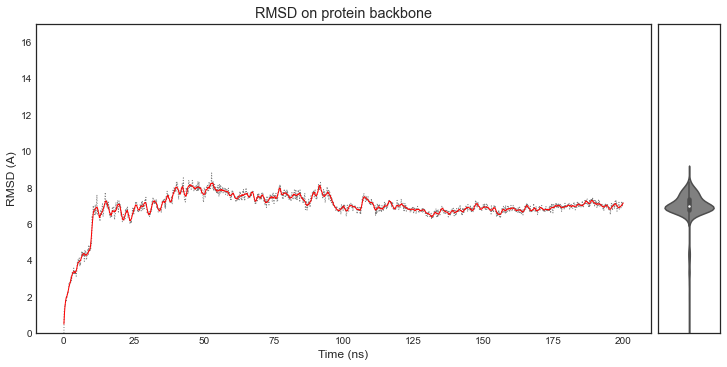

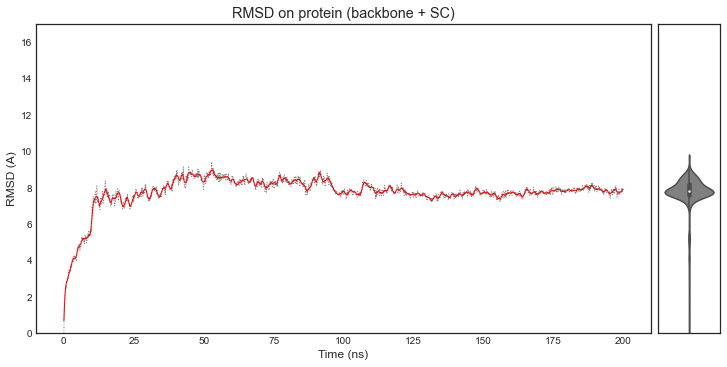

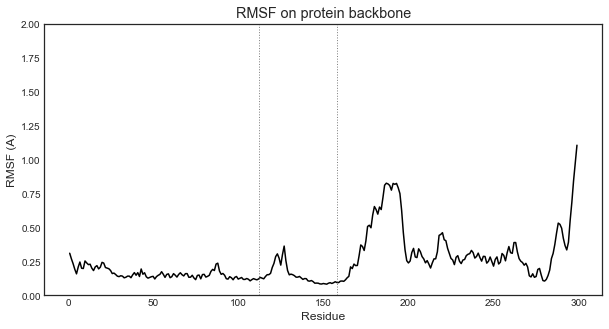

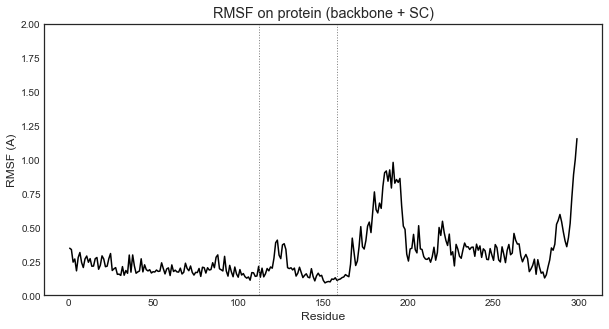

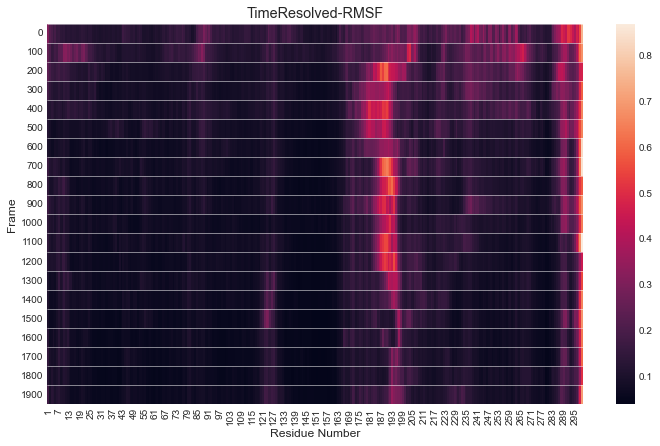

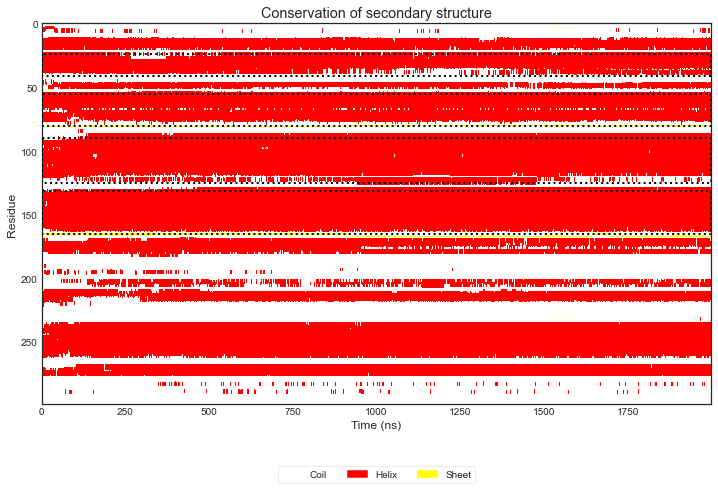

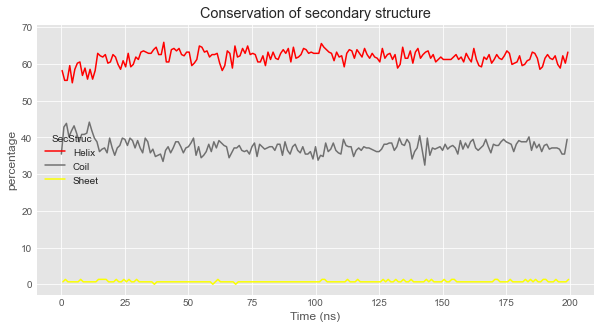

<Figure size 720x360 with 0 Axes>

<Figure size 864x648 with 0 Axes>

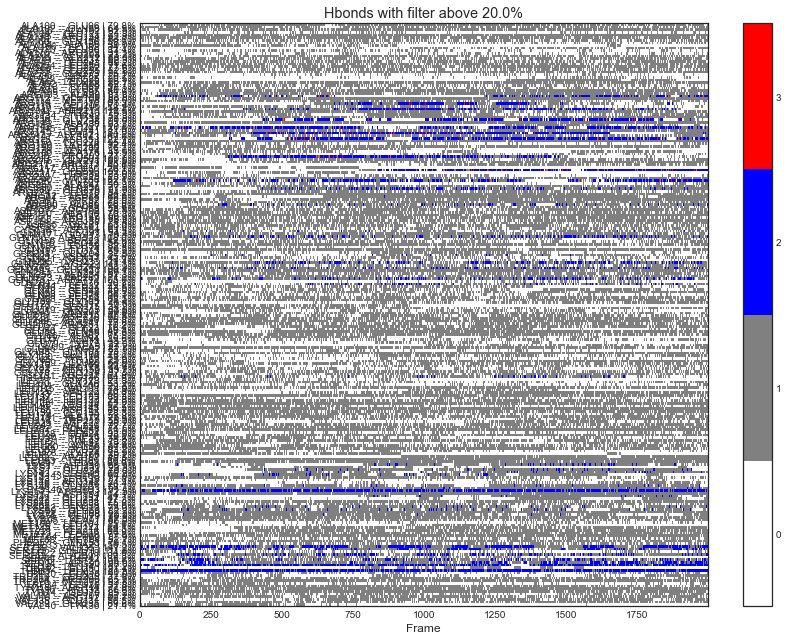

<Figure size 720x360 with 0 Axes>

<Figure size 864x648 with 0 Axes>

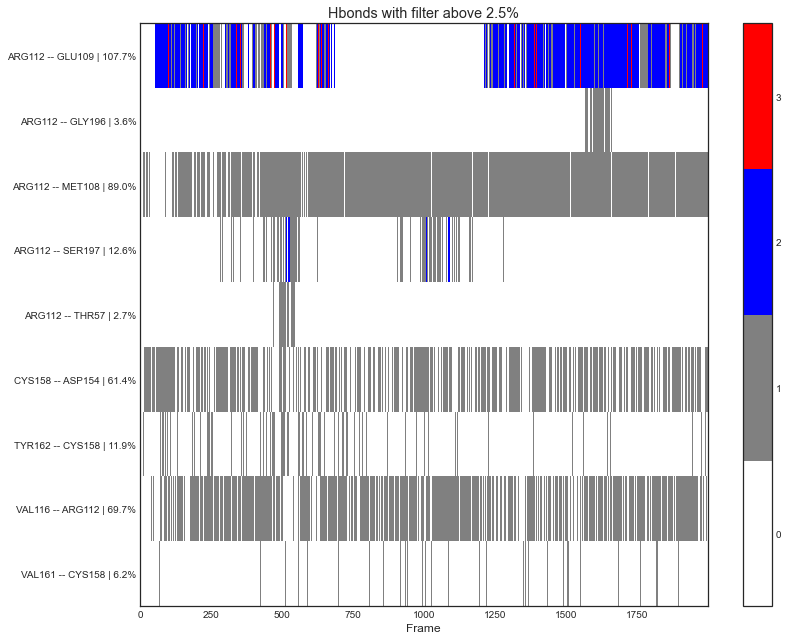

<Figure size 720x360 with 0 Axes>

<Figure size 864x648 with 0 Axes>

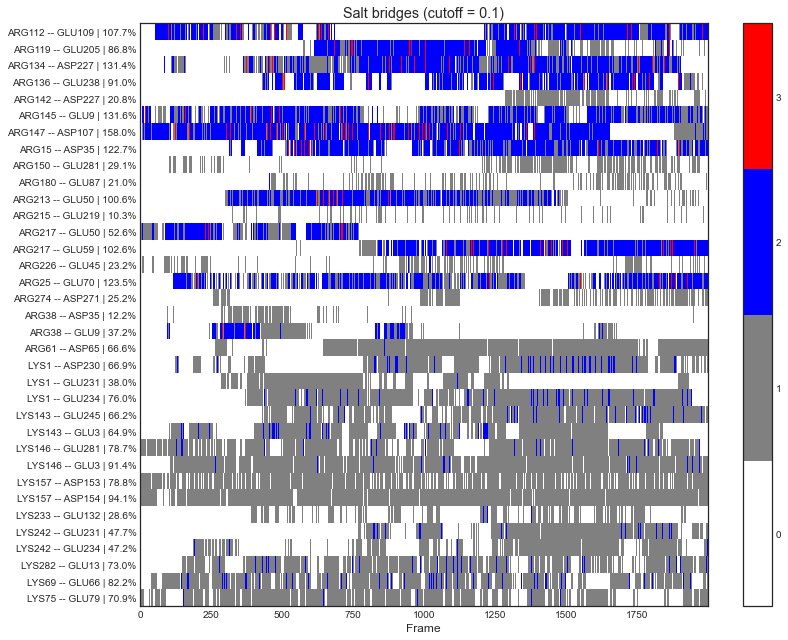

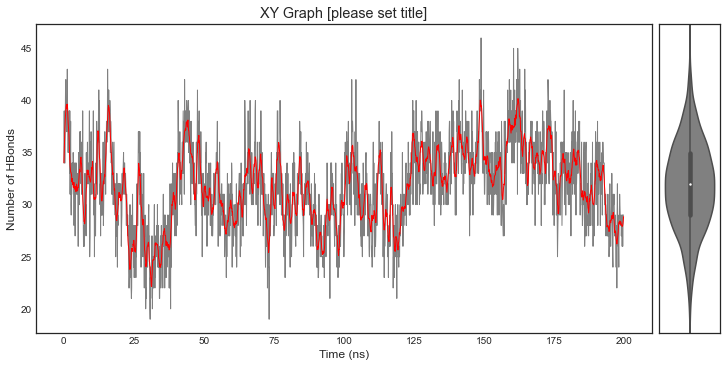

In [30]:
count=0

# 1. Alignement
count+=1
print(f"{count}. Alignment")
traj = do_alignment(traj, "backbone")

# 2. RMSD - BACKBONE
count+=1
print(f"{count}. RMSD - BACKBONE")
rmsd_backbone = do_rmsd(traj, "backbone")
Graph_XY(rmsd_backbone, X="Time (ns)", Y="RMSD (A)",
         title="RMSD on protein backbone")
save_fig("RMSD_backbone", outputPNGdir)
rmsd_backbone.to_csv(f"{outputCSVdir}/RMSD_backbone.csv", sep=";", index=False)

# 3. RMSD - protein
count+=1
print(f"{count}. RMSD - protein (complete)")
rmsd_protein = do_rmsd(traj, "protein")
Graph_XY(rmsd_protein, X="Time (ns)", Y="RMSD (A)",
         title="RMSD on protein (backbone + SC)")
save_fig("RMSD_protein", outputPNGdir)
rmsd_protein.to_csv(f"{outputCSVdir}/RMSD_protein.csv", sep=";", index=False)


# 4. RMSF - BACKBONE
count+=1
print(f"{count}. RMSF - BACKBONE")
rmsf_backbone = do_rmsf(traj, "backbone")
graph_RMSF(rmsf_backbone, X="Residue", Y="RMSF (A)",
         title="RMSF on protein backbone", col='black', vlines=[112,158])
save_fig("RMSF_backbone", outputPNGdir)
rmsf_backbone.to_csv(f"{outputCSVdir}/RMSF_backbone.csv", sep=";", index=False)

# 5. RMSD - protein
count+=1
print(f"{count}. RMSF - protein (complete)")
rmsf_protein = do_rmsf(traj, "protein")
graph_RMSF(rmsf_protein, X="Residue", Y="RMSF (A)",
         title="RMSF on protein (backbone + SC)", col="black", vlines=[112,158])
save_fig("RMSF_protein", outputPNGdir)
rmsf_protein.to_csv(f"{outputCSVdir}/RMSF_protein.csv", sep=";", index=False)


# 6. TRRMSF - backbone
count+=1
print(f"{count}. TRRMSF on backbone")
trrmsf_backbone = do_TRRMSF(traj, "backbone", 100)
graph_TRRMSF(trrmsf_backbone)
save_fig("TRRMSF_backbone", outputPNGdir)
trrmsf_backbone.to_csv(
    f"{outputCSVdir}/TRRMSF_backbone.csv", sep=";", index=False)

# 7. DSSP
count+=1
print(f"{count}. DSSP conservation")
dss_protein = do_secstruc(traj, "protein")
graph_SS(dss_protein, title="Conservation of secondary structure", regions={"H1":[24,41],"H2":[55,80],"H3":[90,125],"H4":[131,165]})
save_fig("secstruct", outputPNGdir)
dss_protein.to_csv(f"{outputCSVdir}/secstruc.csv", sep=";", index=False)

count+=1
print(f"{count}. DSSP conservation (summary)")
Graph_SS_percentage(dss_protein, title="Conservation of secondary structure")
save_fig("secstruct_conservation", outputPNGdir)


# 8. RMSD - protein
print(">> Alignment on Nter")
traj = do_alignment(traj, "backbone and residue 1 to 205")
count+=1
print(f"{count}. RMSD - protein backbone 1-205")
rmsd_protein_nter = do_rmsd(traj, " backbone and residue 1 to 205")
Graph_XY(rmsd_protein_nter, X="Time (ns)", Y="RMSD (A)",
         title="RMSD on Nter backbone (1-205))")
save_fig("RMSD_protein_nter", outputPNGdir)
rmsd_protein_nter.to_csv(f"{outputCSVdir}/RMSD_protein_nter.csv", sep=";", index=False)

#  Gyration
count+=1
print(f"{count}. Radius of gyration - protein (complete)")
rmsf_protein = do_rmsf(traj, "backbone and residue 1 to 205")
Graph_XY(rmsf_protein, X="Residue", Y="Gyration (A)",
         title="Radius of gyration Nter (backbone)", col="black")
save_fig("RG_backbone_Nter", outputPNGdir)
rmsf_protein.to_csv(f"{outputCSVdir}/RG_backbone_Nter.csv", sep=";", index=False)

#########################
# HBONDS
#########################
count+=1
print(f"{count}. Hbond - protein (complete)")
hbonds = do_hbonds(traj,"protein", "protein")

graph_HBOND(hbonds, cutoff=0.2, grouped=False)
save_fig("hbonds_protein_details", outputPNGdir)
graph_HBOND(hbonds, cutoff=0.2, grouped=True)
save_fig("hbonds_protein_AA", outputPNGdir)
calc_summed_graph(hbonds, title="Number of Hbonds in the protein")
save_fig("hbonds_protein_cumsum", outputPNGdir)

count+=1
print(f"{count}. Hbond - Mutations site")

# honds_mut_calc = do_hbonds(traj, "residue 114 or residue 158", "protein")
hbonds_mut = filter_hbonds(traj, hbonds, "residue 112 or residue 158")
graph_HBOND(hbonds_mut, cutoff=0.025, grouped=False)
save_fig("hbonds_112-158_details", outputPNGdir)
graph_HBOND(hbonds_mut, cutoff=0.025, grouped=True)
save_fig("hbonds_112-158_AA", outputPNGdir)
calc_summed_graph(hbonds_mut, title="Number of hbonds with residues 112/158")
save_fig("hbonds_112-158_cumsum", outputPNGdir)


count+=1
print(f"{count}. Hbond - Saltbridges")
saltbridges = filter_saltbridges(hbonds)
graph_HBOND(saltbridges, cutoff=0.1, grouped=False, title="Salt bridges (cutoff = 0.1)")
save_fig("SB_protein_details", outputPNGdir)
graph_HBOND(saltbridges, cutoff=0.1, grouped=True, title="Salt bridges (cutoff = 0.1)")
save_fig("SB_protein_AA", outputPNGdir)
calc_summed_graph(saltbridges, title="Number of Saltbridges")
save_fig("SB_protein_cumsum", outputPNGdir)


In [31]:
if CLUSTERING:
    !ttclust -f {trajectoryFile} -t {topology} -sa "residue 10 to 200" -sr "backbone"